# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Análise de Imagens Médicas

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**.


## 1. Introdução

Uma determinada fintech focada em consumidores finais pessoa física constataou um grande número de fraudes em transações bancárias.

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal, e após isso transferir para outras contas desconhecidas. 

Após análises pelas equipes de segurança, os protocolos de utilização da senha foram realizados em conformidade, ou seja, cada cliente autenticou com sua própria senha de maneira regular.

Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo parecido.

Uma das formas de solucionar ou minimizar este problema é com a utilização de outras formas de autenticação, sobretudo em operações críticas, como a obtenção de crédito pessoal.

Desta forma podemos implementar uma verificação de identidade com prova de vida (liveness), que utilize uma verificação e identificação facial. 

Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.

Será necessário construir:

* Detector de faces
* Identificação de faces (podendo ser um comparador entre um rosto de documento e outra da prova de vida)
* Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.


>Formas alternativas de prover a identificação e prova de vivacidade, além destas que foram solicitadas poderão ser submetidas.


<p align="center">
    <img src="imagens/liveness.jpg">
</p>

Imagem retirada do [Grunge](https://www.grunge.com/192826/company-testing-robocop-facial-recognition-software-with-us-police/).

## 2. Instruções

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas.

Iremos constuir uma forma de validar se uma determinada imagem foi ou não adulterada e se trata de uma produção fraudade.

Existem diversas formas de validar a vivacidade, e neste sentido conto com a criatividade de vocês dado que já dominam encontrar uma face numa imagem, aplicar marcos faciais e até mesmo construir uma rede neural convulacional.

A abordagem mais simples é pela construção de uma rede neural com imagens de fotos de rostos de outras fotos e fotos de rostos sem modificações. Tal classificador deverá classificar se dada imagem possui vivacidade ou não com uma pontuação de probabilidade.

Referências que abordam o tema para servir de inspiração:

1. [PyImageSearch](https://pyimagesearch.com/2019/03/11/liveness-detection-with-opencv/), Liveness detection with OpenCV;
2. [Kickertech](https://kickertech.com/face-liveness-detection-via-opencv-and-tensorflow/), Liveness detection via OpenCV and Tensorflow.
3. [Towards Data Science](https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3?gi=24f8e1b740f9), Real-time face liveness detection with Python, Keras and Opencv2.

Este projeto poderá ser feita por grupos de até 4 pessoas.
Caso este projeto seja substitutivo, deverá ser realizado por apenas uma pessoa.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :-------------| :-----: |
| Vinícius Marcili         | RM 345167      | 1IAR |
| Guilherme             | RM 346006      | 1IAR |
| Fabiana            | RM 345858      | 1IAR |

## 3. Abordagem e organização da solução do problema (2 pontos)

Como o grupo pretende deteccar a prova de vivacidade de uma determinada imagem? Quais os passos e os building blocks deste processo?

**Resposta**:
- Para fazer a prova de vivacidade vamos ter amostras de fotos comuns e fotos de fotos (fakes). Tudo isso no mesmo dataset já com uma coluna indentificando se a foto é real ou fake (coluna type, 0 ou 1).
- Antes de treinar o modelo vamos tirar as faces independente do tipo da imagem
- Depois vamos duplicar a base toda para ter um número maior de amostras, aplicando uma transformação de espelhamento
- Separar em treino e teste
- Contruir a rede CNN com `binary_crossentropy` para ter uma saida de % de vivacidade
- A saida deve ser um número que representa a porcantegem de vivavidade da foto

## 4 Desenvolvimento da solução (5,5 pontos)

Detalhe o passo-a-passo do algoritmo de deteção de vivacidade.
Se optar pela construção e treinamento de um modelo de redes neurais convulucionais, apresente a arquitetura, prepare os dados de treinamento, realize o treinamento.

### 4.1 Organização de dados para treinamento de modelo de liveness (2 pontos)

In [341]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import cv2
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from os import path
%matplotlib inline

In [342]:
# Definindo um tamanho para padronizar as imagens
IMAGE_SIZE = [192, 192]
BATCH_SIZE = 25

In [343]:
# Instanciando classificador de faces
haarcascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [344]:
# Pegando todas as imagens da pasta samples
images = []
for dirname, _, filenames in os.walk('samples'):
  for filename in filenames:
    images.append(os.path.join(dirname, filename))
images = pd.DataFrame(images, columns=['filenames'])

In [345]:
# Atribuindo o nome da pessoa ao caminho da imagem e o tipo da imagem (real [1] ou fake [0])
images['name'] = images['filenames'].apply(lambda x: x.split('/')[1])
images['type'] = images['filenames'].apply(lambda x: 1 if 'Selfie' in x.split('/')[2].split('_')[0] else 0)
images.head(5)

,filenames,name,type
0,samples/Ewa/Selfie_9.jpg,Ewa,1
1,samples/Ewa/Selfie_1.jpg,Ewa,1
2,samples/Ewa/Selfie_5.jpg,Ewa,1
3,samples/Ewa/Selfie_10.jpg,Ewa,1
4,samples/Ewa/Selfie_2.jpg,Ewa,1


In [346]:
images.__len__()

430

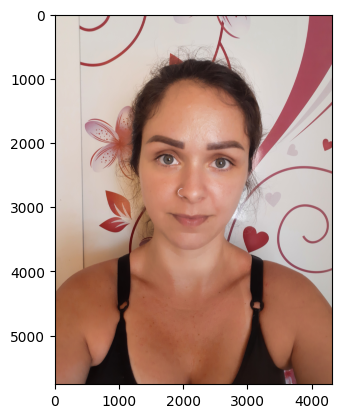

In [347]:
# Pegando uma imagem para testar o pré processamento
imagem = cv2.imread(images['filenames'][181])
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
plt.imshow(imagem)

In [348]:
# Função para extrair a face da imagem
def get_face(img):
  imagem_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = haarcascade.detectMultiScale(imagem_gray, 1.3, 5)
  
  if np.array_equal(faces, ()):
    return None
  
  for (x,y,w,h) in faces:
    result = img[y:y+h, x:x+w]
  
  return cv2.cvtColor(cv2.resize(result, IMAGE_SIZE, interpolation=cv2.INTER_LANCZOS4), cv2.COLOR_BGR2GRAY)

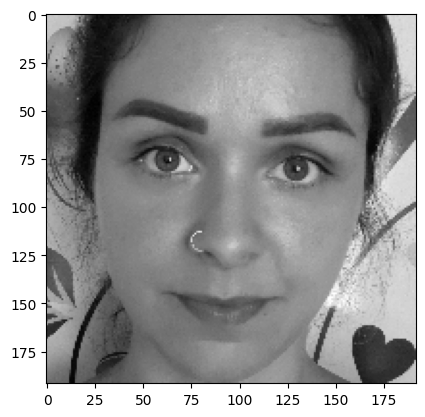

In [349]:
# Resultado
roi = get_face(imagem)
plt.imshow(roi, cmap="gray")

In [350]:
# Extraindo faces e removendo imagens que não possuem faces
images.loc[:, 'face'] = images['filenames'].apply(lambda x: get_face(cv2.imread(x)))
images = images.dropna()
images.head(5)

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

,filenames,name,type,face
1,samples/Ewa/Selfie_1.jpg,Ewa,1,"[[72, 68, 52, 74, 69, 76, 74, 80, 81, 69, 82, ..."
2,samples/Ewa/Selfie_5.jpg,Ewa,1,"[[175, 173, 172, 180, 176, 176, 180, 175, 176,..."
3,samples/Ewa/Selfie_10.jpg,Ewa,1,"[[131, 131, 134, 129, 129, 130, 129, 125, 130,..."
4,samples/Ewa/Selfie_2.jpg,Ewa,1,"[[186, 182, 184, 187, 186, 188, 182, 185, 187,..."
5,samples/Ewa/ID_2.jpg,Ewa,0,"[[153, 153, 154, 154, 153, 151, 152, 150, 151,..."


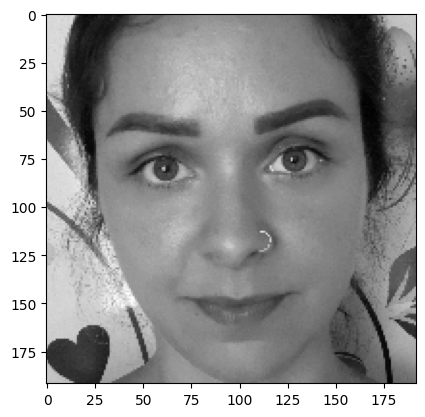

In [351]:
# flip
roi2 = cv2.flip(roi, 1)
plt.imshow(roi2, cmap="gray")

In [352]:
# Duplicando dados com o flip para aumentar o dataset
images = pd.concat([images, images], axis=0)
images = images.reset_index(drop=True)
images.loc[int(len(images)/2):, 'face'] = images['face'].apply(lambda x: cv2.flip(x, 1))

In [353]:
def train_test_validation_split(dataset, dataset_size, train_split=0.7, val_split=0.15, test_split=0.15):
  assert (train_split + test_split + val_split) == 1
 
  train_size = int(train_split * dataset_size)
  val_size = int(val_split * dataset_size)

  train_ds = dataset[:train_size]
  val_ds = dataset[train_size:train_size + val_size + 1]
  test_ds = dataset[train_size + val_size + 1:]
  
  return train_ds, val_ds, test_ds

In [354]:
# total
images.__len__()

786

In [355]:
# split dataset para o detector de faces
X_train, X_test, y_train, y_test = train_test_split(images['face'], images['name'], test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(628, 158, 628, 158)

In [356]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [357]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train = np.array([np.array(xi) for xi in X_train])
X_test = np.array([np.array(xi) for xi in X_test])

In [358]:
# Transformando os nomes em labels númericas
le = preprocessing.LabelEncoder()
le.fit(list(set(images['name'])))
y_train_labels = le.transform(y_train)
y_test_labels = le.transform(y_test)

y_train_labels[0], y_train[0]

(0, 'Alejandra')

In [359]:
le_dict = dict(zip(le.transform(le.classes_), le.classes_))
le_dict

{0: 'Alejandra',
 1: 'Alessandro',
 2: 'Anastasia',
 3: 'Andrea',
 4: 'Anna',
 5: 'Bruno',
 6: 'Clarissa',
 7: 'Daiane',
 8: 'Diego',
 9: 'Ewa',
 10: 'Fernanda',
 11: 'Gabriel',
 12: 'Iasmin',
 13: 'Juliana',
 14: 'Kasia',
 15: 'Kateryna',
 16: 'Klara',
 17: 'Luis',
 18: 'Mark',
 19: 'Massimiliano',
 20: 'Matheus',
 21: 'Mia',
 22: 'Mykhailo',
 23: 'Paolo',
 24: 'Rayanne',
 25: 'Valeria',
 26: 'Vinicius',
 27: 'Vitalijs',
 28: 'Weslley'}

In [360]:
## Face Recognition
modelo_lbph = cv2.face.LBPHFaceRecognizer_create()
modelo_lbph.train(X_train, y_train_labels)
y_pred_lbph = []

for item in tqdm(X_test):
    y_pred_lbph.append(modelo_lbph.predict(item)[0])
    
acuracia_lbph = accuracy_score(y_test_labels, y_pred_lbph)

acuracia_lbph

100%|██████████| 158/158 [00:07<00:00, 20.86it/s]


0.8734177215189873

In [361]:
## Teste de reconhecimento com imagem real
imagem = cv2.imread('samples/Vinicius/Selfie_1.jpg')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
roi = get_face(imagem)
modelo_lbph.predict(roi)

(26, 32.3940021282752)

In [362]:
## Teste de reconhecimento com imagem fake
imagem = cv2.imread('samples/Vinicius/ID_1.jpg')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
roi = get_face(imagem)

modelo_lbph.predict(roi)

(26, 55.49265210837178)

### 4.2 Treinamento de modelo de liveness (1,5 pontos)

In [363]:
X_train_liveness, X_test_liveness, y_train_liveness, y_test_liveness = train_test_split(images['face'], images['type'], test_size=0.2, random_state=42)

In [364]:
y_train_liveness = y_train_liveness.to_numpy()
y_test_liveness = y_test_liveness.to_numpy()

In [365]:
X_train_liveness = X_train_liveness.to_numpy()
X_test_liveness = X_test_liveness.to_numpy()
X_train_liveness = np.array([np.array(xi) for xi in X_train_liveness])
X_test_liveness = np.array([np.array(xi) for xi in X_test_liveness])

X_train_liveness.shape, X_test_liveness.shape, y_train_liveness.shape, y_test_liveness.shape

((628, 192, 192), (158, 192, 192), (628,), (158,))

In [366]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=[*IMAGE_SIZE, 1]),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(3),
  tf.keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [367]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 192, 192, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 96)        27744     
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 96)        83040     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 21, 21, 96)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 42336)            

In [368]:
optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [369]:
history = model.fit(X_train_liveness, y_train_liveness, epochs=5, steps_per_epoch=(X_train_liveness.__len__())//BATCH_SIZE, validation_split=0.1, shuffle=False, use_multiprocessing=True)

Epoch 1/5
25/25 [==============================] - 15s 549ms/step - loss: 0.5969 - accuracy: 0.7327 - val_loss: 1.5138 - val_accuracy: 0.8413
Epoch 2/5
25/25 [==============================] - 11s 448ms/step - loss: 0.4776 - accuracy: 0.8690 - val_loss: 1.1135 - val_accuracy: 0.8413
Epoch 3/5
25/25 [==============================] - 10s 414ms/step - loss: 0.4067 - accuracy: 0.8690 - val_loss: 0.6364 - val_accuracy: 0.8413
Epoch 4/5
25/25 [==============================] - 9s 379ms/step - loss: 0.3589 - accuracy: 0.8761 - val_loss: 2.3171 - val_accuracy: 0.8413
Epoch 5/5
25/25 [==============================] - 9s 378ms/step - loss: 0.2967 - accuracy: 0.9009 - val_loss: 0.8141 - val_accuracy: 0.8413


### 4.3 Métricas de desempenho do modelo (2 pontos)

In [370]:
eval = model.evaluate(X_test_liveness, y_test_liveness, batch_size=BATCH_SIZE, verbose=1, use_multiprocessing=True)
eval

7/7 [==============================] - 0s 65ms/step - loss: 0.6241 - accuracy: 0.8861


[0.6241296529769897, 0.8860759735107422]

In [371]:
print("Accuracy: %.2f%%" % (eval[1]*100))

Accuracy: 88.61%


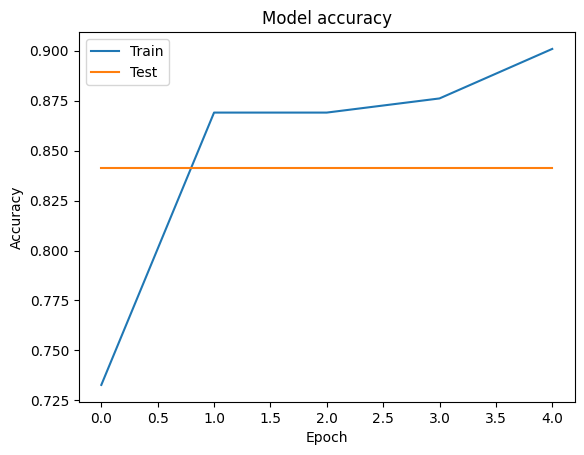

In [372]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 5 Teste Fim-a-Fim

Simule a operação fim-a-fim, com uma imagem de entrada forjada (foto de foto de um rosto) e outra com uma imagem de rosto, exibindo o resultado da classificação e a pontuação de cada classe.

In [373]:
def get_face_liveness(image_path):
  if (image_path is None or not str(path.exists(image_path))):
    return None
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = get_face(image)
  if (image is None):
    return None
  image = image.reshape(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
  return image

def predict_liveness(image_path):
  face = get_face_liveness(image_path)
  if (face is None):
    return None
  return model.predict(face)[0][0] * 100

def predict_name(image_path):
  if (image_path is None or not str(path.exists(image_path))):
    return None
  face = cv2.imread(image_path)
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
  face = get_face(face)
  predict = modelo_lbph.predict(face)
  return le_dict[predict[0]], predict[1]

In [374]:
# Imagem real
IMAGE = 'samples/Iasmin/Selfie_2.jpg'
face_detector_result = predict_name(IMAGE)
liveness_result = predict_liveness(IMAGE)
print("Nome: ", face_detector_result[0])
print("Confiança do nome: {}%".format(round(face_detector_result[1], 2)))
print("Confiança de vivacidade da foto: {}%".format(round(liveness_result, 2)))

1/1 [==============================] - 0s 105ms/step
Nome:  Iasmin
Confiança do nome: 25.85%
Confiança de vivacidade da foto: 99.86%


In [375]:
# Imagem de um documento
IMAGE = 'samples/Iasmin/ID_1.jpg'
face_detector_result = predict_name(IMAGE)
liveness_result = predict_liveness(IMAGE)
print("Nome: ", face_detector_result[0])
print("Confiança do nome: {}%".format(round(face_detector_result[1], 2)))
print("Confiança de vivacidade da foto: {}%".format(round(liveness_result, 2)))

1/1 [==============================] - 0s 22ms/step
Nome:  Iasmin
Confiança do nome: 17.67%
Confiança de vivacidade da foto: 99.62%


>Com a implementação da solução na forma de uma aplicação do [Streamlit](https://www.streamlit.io/) (veja a pata streamlit-app e use o template) vale 1 ponto adicional.

**Pergunta**: Se utilizou o Streamlit, compartilhe a URL do aplicativo publicado:

**Resposta**:

## 6 Conclusões (2,5 pontos)

**Pergunta**: Dado todo o estudo e pesquisa, quais foram as conclusões sobre a solução, o que funcionou, o que não funcionou e quais os detalhes que observariam numa nova versão e melhorias do processo?

**Resposta**:

Primeira observação duranta o teste com algumas amostras foi uma porcentagem, mesmo que baixa, do detector de faces `haarcascades` pegar uma face "inexistente" como uma porta de armário que estava no fundo da foto. Talvez para refinar o modelo seja necessario refinar o uso do detector de faces, tralvez usar um que pegue com mais features como mostrado na aula.

Por se tratar de uma dataset de imagens, acabamos encontrado algumas na internet e pra não ficar muito pesado ficamos com poucas amostras mesmo. Acredito que com uma base maior daria pra melhorar e muito o processo.

Uma técnica que usamos que fui muito util, foi a de dobrar o tamanho do dataset criando novas imagens apenas aplicando um espelhamento delas. Uma ideia aqui seria talvez aplicar outras transformações, como rotação e assim aumentar mais ainda a base toda.

Sobre o modelo de classificação de faces fizemos bem parecido como que foi dado em aula, com algumas adaptações ficando uma acuracia bem satisfatória.

E por ultimo sobre o modelo de vivacidade, como separamos o dataset com as imagens que era fakes e o que não era conseguimos uma accuraria boa mesmo com apenas 5 epocas. Uma observação interessante aqui é que a base está desbalanceada entre fakes e não fakes. (13 imagens reais para 2 fakes). Acredito que se tivessemos algo próximo de 50% de cada ou pelo menos 60%/40% já melhoria bastante a acertividade do modelo.
Apesar do modelo ter uma acuraria alta, rodando testes, em alguns casos ele ainda apontava uma porcentagem bem alta de vivacidade em imagens fakes. Pode ser pela falta de amostra citada ou por falta de aplicação de mais filtros nas imagens, talvez tentar validar a textura da foto.